# Projet d'Analyse des Données Netflix

## 🎯 Objectifs :
Ce projet vise à analyser les données Netflix en extrayant et nettoyant les informations des films et séries.

## 📂 Fichiers utilisés :
- `netflix_titlesata.csv`

## 🏆 Étapes réalisées :
✔️ Extraction et nettoyage des données  
✔️ Création de plusieurs DataFrames  
✔️ Export en fichiers CSV  
✔️ Génération des requêtes SQL  
✔️ Création de visualisations pertinentes  


# 📥 Chargement des Données Netflix

Nous chargeons les fichiers CSV et effectuons quelques prétraitements pour assurer la qualité des données.


In [3]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import plotly.express as px
import numpy as np
import os
import re

# Charger le fichier CSV
file_path = "C:/Users/Utilisateur/Downloads/netflix_titles.csv"
netflix_data = pd.read_csv(file_path, sep=';', on_bad_lines='skip', encoding="utf-8")

# Extraire la première colonne (id)
id_column = netflix_data.columns[0]
# crée le dossier destination
output_folder = "dataframes"
os.makedirs(output_folder, exist_ok=True)

# 🛠️ Correction et 🧹 Nettoyage des Données


Les corrections suivantes ont été effectuées :Verifier les 6 dimensions de qualité des données : Précision, Compéltude, Cohérence, Unicité, Validité, Ponctualité._

Certaines erreurs et valeurs manquantes sont présentes dans notre dataset :
- Suppression ou remplacement des valeurs `NaN`
- Conversion des dates (`date_added`) et des années (`release_year`)
- Détection et correction des erreurs où `date_added` < `release_year`
- Normalisation des données (`country`, `listed_in`) pour éviter les valeurs multiples en une seule cellule
range`)


In [5]:
def verifier_qualite(netflix_data):
    resultats = {}
    # Vérification des années de sortie (Précision)
    annees_valides = True
    for annee in netflix_data['release_year']:
        try:
            annee = int(annee)  # Convertir en entier
            if not (1900 <= annee <= datetime.now().year):
                annees_valides = False
                break
        except ValueError:
            annees_valides = False
            break
    resultats['precision_release_year'] = annees_valides

    # Vérification des classifications (Précision)
    ratings_list = [ "PG", "PG-13", "TV-MA", "TV-14", "TV-PG", "G", "NC-17",
                    "R", "NR","TV-Y", "TV-Y7", "TV-G", "TV-PG", "TV-14","TV-Y7-FV","UR" ]
    classifications_valides = True
    for rating in netflix_data['rating']:
        if rating not in ratings_list and not pd.isnull(rating):
            classifications_valides = False
            break
    resultats['precision_rating'] = classifications_valides

    # Vérification des dates d'ajout (Validité)
    dates_valides = True
    for date in netflix_data['date_added']:
        try:
            pd.to_datetime(date)
        except Exception:
            dates_valides = False
            break
    resultats['validite_date_added'] = dates_valides

    # Vérification des durées (Validité)
    durees_valides = True
    for duree in netflix_data['duration']:
        if not ("min" in str(duree) or "Season" in str(duree)):
            durees_valides = False
            break
    resultats['validite_duration'] = durees_valides

    # Vérification des types (Cohérence)
    types_valides = True
    for t in netflix_data['type']:
        if t not in ["Movie", "TV Show"]:
            types_valides = False
            break
    resultats['coherence_type'] = types_valides

    # Vérification des valeurs manquantes (Complétude)
    valeurs_completes = not netflix_data.isnull().any().any()
    resultats['completeness'] = valeurs_completes

    # Vérification de l'unicité des show_id
    unicite_show_id = len(netflix_data['show_id']) == len(set(netflix_data['show_id']))
    resultats['unicite_show_id'] = unicite_show_id

    return resultats

In [6]:
verifier_qualite(netflix_data)

{'precision_release_year': False,
 'precision_rating': False,
 'validite_date_added': False,
 'validite_duration': False,
 'coherence_type': False,
 'completeness': False,
 'unicite_show_id': True}

In [7]:
#completeness
missing_values = netflix_data.isnull().sum()
print("Valeurs manquantes par colonne :")
print(missing_values)

Valeurs manquantes par colonne :
show_id            0
type               1
title              2
director        2636
cast             826
country          833
date_added        12
release_year       2
rating             6
duration           5
listed_in          3
description        3
dtype: int64


In [8]:
#precision_rating
ratings_list = ["PG", "PG-13", "TV-MA", "TV-14", "TV-PG", "G", "NC-17",
                "R", "NR","TV-Y", "TV-Y7", "TV-G", "TV-PG", "TV-14","TV-Y7-FV","UR" ]

invalid_ratings = netflix_data[~netflix_data['rating'].isin(ratings_list) ]
print("Classifications invalides :")
print(invalid_ratings[['show_id', 'rating']])

Classifications invalides :
                   show_id                         rating
5541               NEs5542                         74 min
5794               NEs5795                         84 min
5813               NEs5814                         66 min
5989               NEs5990                            NaN
6827               NEs6828                            NaN
7312               NEs7313                            NaN
7537               NEs7538                            NaN
8202   and probably will."                            NaN
8420               NEs8420                            NaN
8421  Flying FortreNEsNEs"  Classic Movies, Documentaries


In [9]:
#corriger le probleme
# Identifier les lignes où la classification contient "min"
rows_with_min_in_rating = netflix_data[netflix_data['rating'].str.contains('min', na=False)]

# Déplacer la valeur de "rating" vers "duration" pour ces lignes
for index in rows_with_min_in_rating.index:
    netflix_data.at[index, 'duration'] = netflix_data.at[index, 'rating']
    netflix_data.at[index, 'rating'] = None  # Supprimer la valeur déplacée dans "rating"

# Vérifier les changements
rows_with_min_in_rating_updated = netflix_data.loc[rows_with_min_in_rating.index, ['show_id', 'rating', 'duration']]
rows_with_min_in_rating_updated


show_id rating duration
5541  NEs5542   None   74 min
5794  NEs5795   None   84 min
5813  NEs5814   None   66 min

In [10]:
# Définir un seuil pour considérer qu'une ligne a "plusieurs" valeurs vides (par exemple, 2 ou plus)
seuil_vides = 4

# Ajouter une colonne qui compte les valeurs vides par ligne
netflix_data['missing_count'] = netflix_data.isnull().sum(axis=1)

# Supprimer les lignes où le nombre de valeurs vides est supérieur ou égal au seuil
netflix_data = netflix_data[netflix_data['missing_count'] < seuil_vides]

In [11]:
netflix_data['missing_count'] > 2

0       False
1       False
2       False
3        True
4       False
        ...  
8804    False
8805     True
8806    False
8807    False
8808    False
Name: missing_count, Length: 8807, dtype: bool

In [12]:
#validite_duration
invalid_durations = netflix_data[~netflix_data['duration'].str.contains("min|Season", na=False)]
print("Durées invalides :")
print(invalid_durations[['show_id', 'duration']])

Durées invalides :
                   show_id                                           duration
8421  Flying FortreNEsNEs"  This documentary centers on the crew of the B-...


In [13]:
# Identifier la ligne problématique
ligne_problematique = netflix_data[
    netflix_data['show_id'].str.contains('Flying FortreNEsNEs', na=False)
]
# Générer un nouvel ID basé sur l'index maximum existant dans la colonne 'show_id'
existing_ids = netflix_data['show_id'].str.extract(r'NEs(\d+)', expand=False).dropna().astype(int)
new_id = f"NEs{existing_ids.max() + 1}" if not existing_ids.empty else "NEs1"


if not ligne_problematique.empty:
    # Corriger la ligne en la décalant à droite
    index = ligne_problematique.index[0]
    nouvelle_ligne = {
        'show_id': new_id,  # Générer un nouvel ID unique
        'type': 'Movie',
        'title': netflix_data.at[index, 'show_id'],  # Décalage à droite
        'director': netflix_data.at[index, 'type'],
        'cast': netflix_data.at[index, 'title'],
        'country': netflix_data.at[index, 'director'],
        'date_added': netflix_data.at[index, 'cast'],
        'release_year': netflix_data.at[index, 'country'],
        'rating': netflix_data.at[index, 'date_added'],
        'duration': netflix_data.at[index, 'release_year'],
        'listed_in': netflix_data.at[index, 'rating'],
        'description': netflix_data.at[index, 'duration']
    }
    
    # Supprimer l'ancienne ligne et ajouter la nouvelle
    netflix_data = netflix_data.drop(index).reset_index(drop=True)
    nouvelle_ligne_netflix_data = pd.DataFrame([nouvelle_ligne])
    netflix_data = pd.concat([netflix_data, nouvelle_ligne_netflix_data], ignore_index=True)
    
print(netflix_data[netflix_data['show_id'] == new_id])

      show_id   type                 title       director cast        country  \
8806  NEs8808  Movie  Flying FortreNEsNEs"  William Wyler  NaN  United States   

          date_added release_year rating duration  \
8806  March 31, 2017         1944  TV-PG   40 min   

                          listed_in  \
8806  Classic Movies, Documentaries   

                                            description  missing_count  
8806  This documentary centers on the crew of the B-...            NaN  


In [14]:
# Expression régulière pour autoriser uniquement lettres, chiffres, espaces et apostrophes
pattern = re.compile(r"^[a-zA-Z0-9\s':&\-!,.(?+*]+$")

# Filtrer les titres qui contiennent d'autres caractères
weird_titles = netflix_data[~netflix_data['title'].apply(lambda x: bool(pattern.match(str(x))))]

# Afficher les titres "bizarres"
weird_titles['title'].to_csv("weird.csv", index = False)


Apres avoir verifié il ya aucun nom incoherent 

In [16]:
#validite_date_added
invalid_dates = netflix_data[netflix_data['date_added'].isnull()]
print("Dates ajoutées invalides :")
print(invalid_dates[['show_id', 'date_added']])


Dates ajoutées invalides :
      show_id date_added
6066  NEs6067        NaN
6174  NEs6175        NaN
6795  NEs6796        NaN
6806  NEs6807        NaN
6901  NEs6902        NaN
7196  NEs7197        NaN
7254  NEs7255        NaN
7406  NEs7407        NaN
7847  NEs7848        NaN
8182  NEs8183        NaN


In [17]:
# Convertir la colonne 'date_added' en format datetime
netflix_data['date_added'] = pd.to_datetime(netflix_data['date_added'], errors='coerce')
# Convertir 'release_year' en entier, remplacer les erreurs par NaN
netflix_data['release_year'] = pd.to_numeric(netflix_data['release_year'], errors='coerce')

# Identifier les lignes où l'année de 'date_added' est antérieure à 'release_year'
invalid_dates = netflix_data[(netflix_data['date_added'].notnull()) & (netflix_data['release_year'].notnull())]
invalid_dates = invalid_dates[invalid_dates['date_added'].dt.year < invalid_dates['release_year']]

# Afficher les lignes invalides
print(invalid_dates['date_added'], invalid_dates['release_year'])


1551   2020-12-14
1696   2020-11-15
2920   2020-02-13
3168   2019-12-06
3287   2019-11-13
3369   2019-10-25
3433   2019-10-11
4844   2018-05-30
4845   2018-05-29
5394   2017-07-01
5658   2016-12-23
5677   2016-12-13
7063   2018-10-26
7112   2013-03-31
Name: date_added, dtype: datetime64[ns] 1551    2021
1696    2021
2920    2021
3168    2020
3287    2020
3369    2020
3433    2020
4844    2019
4845    2019
5394    2018
5658    2018
5677    2017
7063    2019
7112    2016
Name: release_year, dtype: int64


# 📊 Création des DataFrames Netflix

Nous créons des tables distinctes pour faciliter l'analyse :
- Type (`type`)
- Titre (`title`)
- Réalisateur (`director`)
- Acteurs (`cast`)
- Pays (`country`)
- Durée (`duration`)
- Catégories (`listed_in`)
- Classification (`rating`)
- Date d'ajout sur Netflix (`d
- description de film ou serie (`description_data`)te_added`)


In [19]:
del netflix_data['missing_count']
# Créer des DataFrames pour chaque colonne (sauf la première) et sauvegarder
for column in netflix_data.columns[1:]:
    # Garder la première colonne et la colonne actuelle
    data = netflix_data[[id_column, column]].dropna()
    output_file = os.path.join(output_folder, f'{column}_data.csv')
    data.to_csv(output_file, index=False, sep=";")
    print(f"Fichier {output_file} créé avec succès.")

Fichier dataframes\type_data.csv créé avec succès.
Fichier dataframes\title_data.csv créé avec succès.
Fichier dataframes\director_data.csv créé avec succès.
Fichier dataframes\cast_data.csv créé avec succès.
Fichier dataframes\country_data.csv créé avec succès.
Fichier dataframes\date_added_data.csv créé avec succès.
Fichier dataframes\release_year_data.csv créé avec succès.
Fichier dataframes\rating_data.csv créé avec succès.
Fichier dataframes\duration_data.csv créé avec succès.
Fichier dataframes\listed_in_data.csv créé avec succès.
Fichier dataframes\description_data.csv créé avec succès.
Fichier dataframes\missing_count_data.csv créé avec succès.


# 🔢 Génération des Identifiants Uniques (ID)

Pour normaliser les données et éviter les redondances, nous attribuons un **ID unique** à :
- Les types (`type_id`)
- Les titres (`title_id`)
- Les réalisateurs (`director_id`)
- Les acteurs (`actor_id`)
- Les pays (`country_id`)
- Les genres (`listed_in_id`)
- Les dates d'ajout (`date_added_id`)


In [20]:
def split_name_proper(full_name):
    if pd.isna(full_name):
        return pd.Series([None, None])
    names = full_name.split(" ")
    if len(names) > 1:
        return pd.Series([names[-1], " ".join(names[:-1])])  # Nom de famille, puis prénom
    else:
        return pd.Series([full_name, None])  # Si un seul nom est donné
 
# Charger les données
cast_data = pd.read_csv(r'dataframes\\cast_data.csv', sep=';', on_bad_lines='skip')
directors_data = pd.read_csv(r'dataframes\\director_data.csv', sep=';', on_bad_lines='skip')

# Étape 1 : Extraire et exploser les membres du cast
def extract_cast_members(cast):
    if pd.isna(cast):
        return []
    return [actor.strip() for actor in cast.split(",")]

cast_data['cast_members'] = cast_data['cast'].apply(extract_cast_members)
exploded_cast_data = cast_data.explode('cast_members').rename(columns={'cast_members': 'actor'})

# Étape 2 : Ajouter `actor_id` et séparer les noms
exploded_cast_data['actor_id'] = range(1, len(exploded_cast_data) + 1)
exploded_cast_data[['actor_last_name', 'actor_first_name']] = exploded_cast_data['actor'].apply(split_name_proper)

# Étape 3 : Réorganiser les colonnes
exploded_cast_data = exploded_cast_data[['actor_id', 'show_id', 'actor', 'actor_last_name', 'actor_first_name']]
actor_data = exploded_cast_data[['actor_id', 'actor_last_name', 'actor_first_name']].drop_duplicates()
actor_table = exploded_cast_data[['show_id', 'actor_id']]


# Étape 3 : Extraire et exploser les réalisateurs
directors_data['director_members'] = directors_data['director'].apply(extract_cast_members)
exploded_director_data = directors_data.explode('director_members').rename(columns={'director_members': 'directors'})

# Étape 4 : Ajouter `director_id` et séparer les noms
exploded_director_data['director_id'] = range(1, len(exploded_director_data) + 1)
exploded_director_data[['director_last_name', 'director_first_name']] = exploded_director_data['directors'].apply(split_name_proper)

# Réorganiser les colonnes pour les réalisateurs
exploded_director_data = exploded_director_data[['director_id', 'show_id', 'directors', 'director_last_name', 'director_first_name']]
director_data = exploded_director_data[['director_id', 'director_last_name', 'director_first_name']].drop_duplicates()

# 🎬 Création de la table `show_director`
director_table = exploded_director_data[['show_id', 'director_id']]
# 📂 Sauvegarde des DataFrames dans des fichiers CSV
actor_data.to_csv(r'dataframes\\actor_data.csv', index=False, sep=";")
actor_table.to_csv(r'dataframes\\actor_table.csv', index=False, sep=";")
director_data.to_csv(r'dataframes\\director_data.csv', index=False, sep=";")
director_table.to_csv(r'dataframes\\director_table.csv', index=False, sep=";")

# ✅ Suppression des colonnes inutiles après migration des données
del cast_data
del director_data

print("✔️ Tables relationnelles créées avec succès !")

✔️ Tables relationnelles créées avec succès !


In [21]:
actor_table.head(7)

show_id  actor_id
0    NEs2         1
0    NEs2         2
0    NEs2         3
0    NEs2         4
0    NEs2         5
0    NEs2         6
0    NEs2         7

In [22]:
director_table.head(7)

show_id  director_id
0    NEs1            1
1    NEs3            2
2    NEs6            3
3    NEs7            4
3    NEs7            5
4    NEs8            6
5    NEs9            7

In [23]:
def create_id_table(df, column_name, id_name):
    """Crée une table avec ID unique basé sur une colonne spécifique"""
    unique_values = df[[column_name]].drop_duplicates().reset_index(drop=True)
    unique_values[id_name] = range(1, len(unique_values) + 1)
    return unique_values

def split_and_normalize(df, column_name, id_name):
    """Sépare les valeurs multiples, normalise et crée une table avec ID unique"""
    exploded_values = df[column_name].dropna().str.split(",").explode().str.strip().drop_duplicates().reset_index(drop=True)
    exploded_values = pd.DataFrame({column_name: exploded_values})
    exploded_values[id_name] = range(1, len(exploded_values) + 1)
    return exploded_values

# ✅ Génération des tables avec ID unique
type_table = create_id_table(netflix_data, "type", "type_id")
title_table = create_id_table(netflix_data, "title", "title_id")
date_added_table = create_id_table(netflix_data, "date_added", "date_added_id")
release_year_table = create_id_table(netflix_data, "release_year", "release_year_id")
rating_table = create_id_table(netflix_data, "rating", "rating_id")
duration_table = create_id_table(netflix_data, "duration", "duration_id")
country_table = split_and_normalize(netflix_data, "country", "country_id")
listed_in_table = split_and_normalize(netflix_data, "listed_in", "listed_in_id")

output_dir = "dataframes/"
# ✅ Sauvegarde des fichiers ID uniques
type_table.to_csv(f"{output_dir}type_table.csv", index=False, sep=";")
title_table.to_csv(f"{output_dir}title_table.csv", index=False, sep=";")
date_added_table.to_csv(f"{output_dir}date_added_table.csv", index=False, sep=";")
release_year_table.to_csv(f"{output_dir}release_year_table.csv", index=False, sep=";")
rating_table.to_csv(f"{output_dir}rating_table.csv", index=False, sep=";")
duration_table.to_csv(f"{output_dir}duration_table.csv", index=False, sep=";")
country_table.to_csv(f"{output_dir}country_table.csv", index=False, sep=";")
listed_in_table.to_csv(f"{output_dir}listed_in_table.csv", index=False, sep=";")

# ✅ 8️⃣ Création des relations avec `show_id`
show_type = netflix_data[["show_id", "type"]].merge(type_table, on="type", how="left")[["show_id", "type_id"]]
show_title = netflix_data[["show_id", "title"]].merge(title_table, on="title", how="left")[["show_id", "title_id"]]
show_date_added = netflix_data[["show_id", "date_added"]].merge(date_added_table, on="date_added", how="left")[["show_id", "date_added_id"]]
show_release_year = netflix_data[["show_id", "release_year"]].merge(release_year_table, on="release_year", how="left")[["show_id", "release_year_id"]]
show_rating = netflix_data[["show_id", "rating"]].merge(rating_table, on="rating", how="left")[["show_id", "rating_id"]]
show_duration = netflix_data[["show_id", "duration"]].merge(duration_table, on="duration", how="left")[["show_id", "duration_id"]]

# ✅ Fusion correcte
show_director = netflix_data[['show_id']].merge(director_table, on='show_id', how='left')[['show_id', 'director_id']]
show_actor = netflix_data[['show_id']].merge(actor_table, on='show_id', how='left')[['show_id', 'actor_id']]


print("✔️ Toutes les tables avec IDs uniques et relations ont été générées et exportées avec succès !")

✔️ Toutes les tables avec IDs uniques et relations ont été générées et exportées avec succès !


In [24]:
show_director

show_id  director_id
0        NEs1          1.0
1        NEs2          NaN
2        NEs3          2.0
3        NEs4          NaN
4        NEs5          NaN
...       ...          ...
9607  NEs8804          NaN
9608  NEs8805       6975.0
9609  NEs8806       6976.0
9610  NEs8807       6977.0
9611  NEs8808       6978.0

[9612 rows x 2 columns]

In [25]:
date_added_data = pd.read_csv(r'dataframes\\date_added_data.csv', sep=';', on_bad_lines='skip')

# Création de la colonne année de publication (en extrayant l'année de la date d'ajout)
date_added_data['year_added'] = pd.to_datetime(date_added_data['date_added'], errors='coerce').dt.year

# Création de la colonne année_range pour catégoriser les années
def categorize_year(year):
    if pd.isna(year):
        return 'Unknown'
    else:
        return f"{(year // 10) * 10}s"

date_added_data['year_range'] = date_added_data['year_added'].apply(categorize_year)

In [26]:
date_added_data

show_id  date_added  year_added year_range
0        NEs1  2021-09-25        2021      2020s
1        NEs2  2021-09-24        2021      2020s
2        NEs3  2021-09-24        2021      2020s
3        NEs4  2021-09-24        2021      2020s
4        NEs5  2021-09-24        2021      2020s
...       ...         ...         ...        ...
8704  NEs8804  2019-07-01        2019      2010s
8705  NEs8805  2019-11-01        2019      2010s
8706  NEs8806  2020-01-11        2020      2020s
8707  NEs8807  2019-03-02        2019      2010s
8708  NEs8808  2017-03-31        2017      2010s

[8709 rows x 4 columns]

# 🗄️ Génération des Requêtes SQL pour la Base de Données

Pour stocker ces données dans une base relationnelle, nous générons des requêtes SQL permettant d'insérer toutes les informations en base de données.

✅ **Utilisation des tables relationnelles** :  
Chaque table contient des **IDs uniques** permettant d'effectuer des jointures **sans duplication inutile**.

✅ **Exemple de requête SQL générée** :
```sql
INSERT INTO show_title (show_id, title_id) VALUES ('s1', 101);


In [28]:
# List of file paths and corresponding table names
files_and_tables = [
    ("dataframes\\date_added_data.csv", "date_added"),
    ("dataframes\\country_data.csv", "country"),
    ("dataframes\\listed_in_data.csv", "listed_in"),
    ("dataframes\\type_data.csv", "type"),
    ("dataframes\\release_year_data.csv", "release_year"),
    ("dataframes\\duration_data.csv", "duration"),
    ("dataframes\\missing_count_data.csv", "missing_count"),
    ("dataframes\\title_data.csv", "title"),
    ("dataframes\\description_data.csv", "description"),
    ("dataframes\\rating_data.csv", "rating"),
    ("dataframes\\cast_data.csv", "cast"),
    ("dataframes\\director_data.csv", "director")
]

# Append the INSERT query to the existing CSV files without overwriting the netflix_data
def append_insert_to_csv(file_path, table_name):
    # Read the netflix_data from the CSV
    df = pd.read_csv(file_path, sep=';', on_bad_lines='skip')
    
    # Create the INSERT statement
    columns = ", ".join(df.columns)
    values = ", ".join(
        df.apply(
            lambda row: f"({', '.join([repr(val) for val in row.values])})", axis=1
        )
    )
    insert_query = f"INSERT INTO {table_name} ({columns}) VALUES {values};"
    
    # Append the query to the existing file
    output_file = file_path
    with open(output_file, "a", encoding="utf-8") as f:
        f.write(insert_query + "\n")
    return output_file

# Append INSERT queries to the provided files and keep the netflix_data intact
output_files_appended = {}
for file_path, table_name in files_and_tables:
    output_files_appended[table_name] = append_insert_to_csv(file_path, table_name)

output_files_appended


{'date_added': 'dataframes\\date_added_data.csv',
 'country': 'dataframes\\country_data.csv',
 'listed_in': 'dataframes\\listed_in_data.csv',
 'type': 'dataframes\\type_data.csv',
 'release_year': 'dataframes\\release_year_data.csv',
 'duration': 'dataframes\\duration_data.csv',
 'missing_count': 'dataframes\\missing_count_data.csv',
 'title': 'dataframes\\title_data.csv',
 'description': 'dataframes\\description_data.csv',
 'rating': 'dataframes\\rating_data.csv',
 'cast': 'dataframes\\cast_data.csv',
 'director': 'dataframes\\director_data.csv'}

# 🎥 Analyse des Films et Séries sur Netflix

Nous avons créé des DataFrames spécifiques :
- 🎬 `films_only.csv` → Contient uniquement les films
- 📺 `series_only.csv` → Contient uniquement les séries
- 🇫🇷 `productions_france.csv` → Contient uniquement les productions françaises


In [30]:
# Filter for films and series produced in France based on the "country" column
france_productions = netflix_data[netflix_data['country'].str.contains('France', na=False)]

france_productions.to_csv("dataframes/productions_france.csv", index = False, sep=";")
france_productions

show_id     type                       title  \
29      NEs30    Movie                    Paranoia   
91      NEs92    Movie  The Women and the Murderer   
99     NEs100  TV Show                On the Verge   
115    NEs116    Movie                 Bright Star   
122    NEs123    Movie                  In the Cut   
...       ...      ...                         ...   
8714  NEs8716    Movie         Welcome to New York   
8745  NEs8747    Movie                      Winnie   
8775  NEs8777    Movie                  Yellowbird   
8793  NEs8795    Movie                      اشتباك   
8796  NEs8798  TV Show                   Zak Storm   

                                director  \
29                        Robert Luketic   
91    Mona Achache, Patricia Tourancheau   
99                                   NaN   
115                         Jane Campion   
122                         Jane Campion   
...                                  ...   
8714                        Abel Ferrara   
8745                      Pascale Lamche   
8775                   Christian De Vita   
8793                        Mohamed Diab   
8796                                 NaN   

                                                   cast  \
29    Liam Hemsworth, Gary Oldman, Amber Heard, Harr...   
91                                                  NaN   
99    Julie Delpy, Elisabeth Shue, Sarah Jones, Alex...   
115   Abbie Cornish, Ben Whishaw, Paul Schneider, Ke...   
122   Meg Ryan, Mark Ruffalo, Jennifer Jason Leigh, ...   
...                                                 ...   
8714  Gérard Depardieu, Jacqueline Bisset, Marie Mou...   
8745                                                NaN   
8775  Dakota Fanning, Seth Green, Christine Baranski...   
8793  Nelly Karim, Hany Adel, Tarek Abdel Aziz, Ahme...   
8796  Michael Johnston, Jessica Gee-George, Christin...   

                                               country date_added  \
29                        United States, India, France 2021-09-19   
91                                              France 2021-09-09   
99                               France, United States 2021-09-07   
115                  United Kingdom, Australia, France 2021-09-02   
122   United Kingdom, Australia, France, United States 2021-09-02   
...                                                ...        ...   
8714                             United States, France 2017-03-23   
8745        France, Netherlands, South Africa, Finland 2018-02-26   
8775                                   France, Belgium 2015-08-05   
8793                                     Egypt, France 2018-10-11   
8796     United States, France, South Korea, Indonesia 2018-09-13   

      release_year rating   duration  \
29            2013  PG-13    106 min   
91            2021  TV-14     92 min   
99            2021  TV-MA   1 Season   
115           2009     PG    119 min   
122           2003      R    118 min   
...            ...    ...        ...   
8714          2014      R    108 min   
8745          2017  TV-14     85 min   
8775          2014     PG     90 min   
8793          2016  TV-14     98 min   
8796          2016  TV-Y7  3 Seasons   

                                             listed_in  \
29                                           Thrillers   
91                 Documentaries, International Movies   
99                              TV Comedies, TV Dramas   
115                            Dramas, Romantic Movies   
122                                          Thrillers   
...                                                ...   
8714                        Dramas, Independent Movies   
8745               Documentaries, International Movies   
8775                Children & Family Movies, Comedies   
8793  Dramas, Independent Movies, International Movies   
8796                                          Kids' TV   

                                            description  missing_count  
29    Blackmailed by his company's CEO,

In [31]:
movies_only = netflix_data[netflix_data['type'] == 'Movie']
series_only = netflix_data[netflix_data['type'] == 'TV Show']

series_only.to_csv("dataframes/series_only.csv", index = False, sep=";")
series_only

show_id     type                  title         director  \
1        NEs2  TV Show          Blood & Water              NaN   
2        NEs3  TV Show              Ganglands  Julien Leclercq   
3        NEs4  TV Show  Jailbirds New Orleans              NaN   
4        NEs5  TV Show           Kota Factory              NaN   
5        NEs6  TV Show          Midnight Mass    Mike Flanagan   
...       ...      ...                    ...              ...   
8794  NEs8796  TV Show        Yu-Gi-Oh! Arc-V              NaN   
8795  NEs8797  TV Show             Yunus Emre              NaN   
8796  NEs8798  TV Show              Zak Storm              NaN   
8799  NEs8801  TV Show     Zindagi Gulzar Hai              NaN   
8802  NEs8804  TV Show            Zombie Dumb              NaN   

                                                   cast  \
1     Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   
2     Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...   
3                                                   NaN   
4     Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...   
5     Kate Siegel, Zach Gilford, Hamish Linklater, H...   
...                                                 ...   
8794  Mike Liscio, Emily Bauer, Billy Bob Thompson, ...   
8795  Gökhan Atalay, Payidar Tüfekçioglu, Baran Akbu...   
8796  Michael Johnston, Jessica Gee-George, Christin...   
8799  Sanam Saeed, Fawad Khan, Ayesha Omer, Mehreen ...   
8802                                                NaN   

                                            country date_added  release_year  \
1                                      South Africa 2021-09-24          2021   
2                                               NaN 2021-09-24          2021   
3                                               NaN 2021-09-24          2021   
4                                             India 2021-09-24          2021   
5                                               NaN 2021-09-24          2021   
...                                             ...        ...           ...   
8794                                  Japan, Canada 2018-05-01          2015   
8795                                         Turkey 2017-01-17          2016   
8796  United States, France, South Korea, Indonesia 2018-09-13          2016   
8799                                       Pakistan 2016-12-15          2012   
8802                                            NaN 2019-07-01          2018   

     rating   duration                                          listed_in  \
1     TV-MA  2 Seasons    International TV Shows, TV Dramas, TV Mysteries   
2     TV-MA   1 Season  Crime TV Shows, International TV Shows, TV Act...   
3     TV-MA   1 Season                             Docuseries, Reality TV   
4     TV-MA  2 Seasons  International TV Shows, Romantic TV Shows, TV ...   
5     TV-MA   1 Season                 TV Dramas, TV Horror, TV Mysteries   
...     ...        ...                                                ...   
8794  TV-Y7  2 Seasons                             Anime Series, Kids' TV   
8795  TV-PG  2 Seasons                  International TV Shows, TV Dramas   
8796  TV-Y7  3 Seasons                                           Kids' TV   
8799  TV-PG   1 Season  International TV Shows, Romantic TV Shows, TV ...   
8802  TV-Y7  2 Seasons             Kids' TV, Korean TV Shows, TV Comedies   

                                            description  missing_count  
1     After crossing paths at a party, a Cape Town t...            1.0  
2     To protect his family from a powerful drug lor...            1.0  
3     Feuds, flirtations and toilet talk go down amo...            3.0  
4     In a city of coaching centers known to train I...            1.0  
5     The arrival of a charismatic young priest brin...            1.0  
...                                                 ...            ...  
8794  Now that he's discovered the Pendulum Summonin...            1.0  
8795  During the Mongol invasions,

In [32]:
movies_only.to_csv("dataframes/movies_only.csv", index = False, sep=";")
movies_only

show_id   type                             title  \
0        NEs1  Movie              Dick Johnson Is Dead   
6        NEs7  Movie  My Little Pony: A New Generation   
7        NEs8  Movie                           Sankofa   
9       NEs10  Movie                      The Starling   
12      NEs13  Movie                      Je Suis Karl   
...       ...    ...                               ...   
8801  NEs8803  Movie                            Zodiac   
8803  NEs8805  Movie                        Zombieland   
8804  NEs8806  Movie                              Zoom   
8805  NEs8807  Movie                            Zubaan   
8806  NEs8808  Movie              Flying FortreNEsNEs"   

                           director  \
0                   Kirsten Johnson   
6     Robert Cullen, José Luis Ucha   
7                      Haile Gerima   
9                    Theodore Melfi   
12              Christian Schwochow   
...                             ...   
8801                  David Fincher   
8803                Ruben Fleischer   
8804                   Peter Hewitt   
8805                    Mozez Singh   
8806                  William Wyler   

                                                   cast  \
0                                                   NaN   
6     Vanessa Hudgens, Kimiko Glenn, James Marsden, ...   
7     Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...   
9     Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...   
12    Luna Wedler, Jannis Niewöhner, Milan Peschel, ...   
...                                                 ...   
8801  Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...   
8803  Jesse Eisenberg, Woody Harrelson, Emma Stone, ...   
8804  Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...   
8805  Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...   
8806                                                NaN   

                                                country date_added  \
0                                         United States 2021-09-25   
6                                                   NaN 2021-09-24   
7     United States, Ghana, Burkina Faso, United Kin... 2021-09-24   
9                                         United States 2021-09-24   
12                              Germany, Czech Republic 2021-09-23   
...                                                 ...        ...   
8801                                      United States 2019-11-20   
8803                                      United States 2019-11-01   
8804                                      United States 2020-01-11   
8805                                              India 2019-03-02   
8806                                      United States 2017-03-31   

      release_year rating duration  \
0             2020  PG-13   90 min   
6             2021     PG   91 min   
7             1993  TV-MA  125 min   
9             2021  PG-13  104 min   
12            2021  TV-MA  127 min   
...            ...    ...      ...   
8801          2007      R  158 min   
8803          2009      R   88 min   
8804          2006     PG   88 min   
8805          2015  TV-14  111 min   
8806          1944  TV-PG   40 min   

                                             listed_in  \
0                                        Documentaries   
6                             Children & Family Movies   
7     Dramas, Independent Movies, International Movies   
9                                     Comedies, Dramas   
12                        Dramas, International Movies   
...                                                ...   
8801                    Cult Movies, Dramas, Thrillers   
8803                           Comedies, Horror Movies   
8804                Children & Family Movies, Comedies   
8805    Dramas, International Movies, Music & Musicals   
8806                     Classic Movies, Documentaries   

                                            description  missing_count  
0     As her father nears the end of his life, filmm...        

In [33]:
netflix_data.to_csv('netflix_titles.csv', index=False, sep=";")

# 📊 Visualisation des Données Netflix

Nous avons réalisé plusieurs graphiques pour mieux comprendre la répartition des contenus sur Netflix :
- 📅 **Nombre de films et séries par année**
- 🌍 **Top 10 des pays producteurs**
- 🎭 **Genres les plus populaires**
- 📊 **Répartition des classifications d'âge**
- ⏳ **Évolution de la durée moyenne des films**
- 📅 **Nombre de films/séries ajoutés chaque mois**


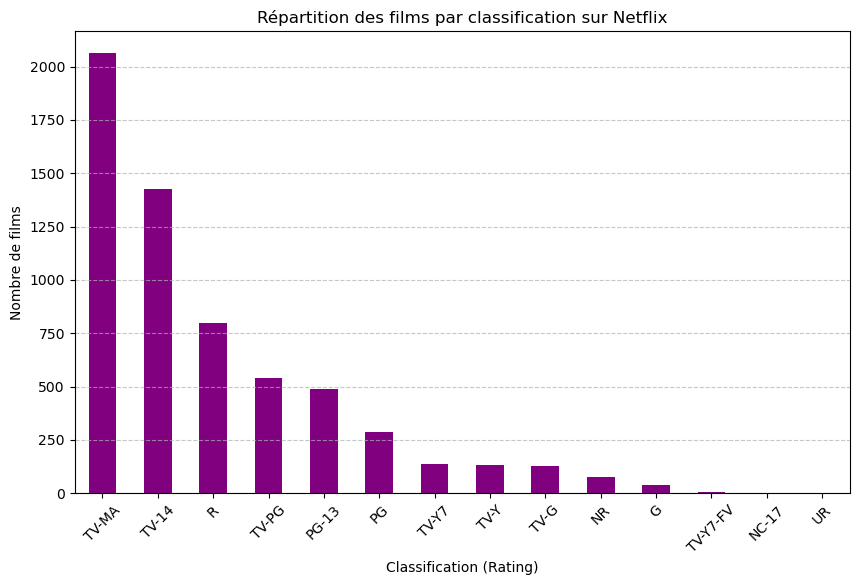

In [36]:
# 2. Distribution of movies by rating
plt.figure(figsize=(10, 6))
movies_only['rating'].value_counts().plot(kind='bar', color='purple')
plt.xlabel("Classification (Rating)")
plt.ylabel("Nombre de films")
plt.title("Répartition des films par classification sur Netflix")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

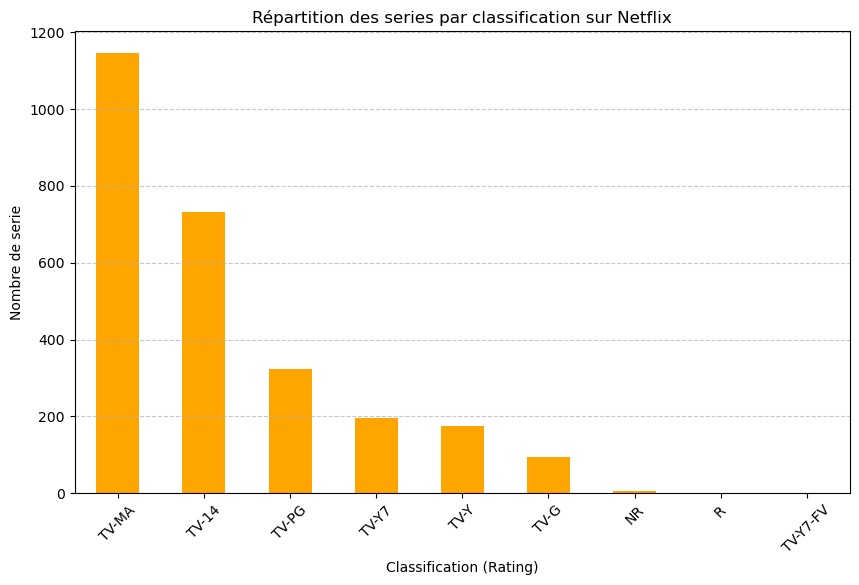

In [37]:
plt.figure(figsize=(10, 6))
series_only['rating'].value_counts().plot(kind='bar', color='orange')
plt.xlabel("Classification (Rating)")
plt.ylabel("Nombre de serie")
plt.title("Répartition des series par classification sur Netflix")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

['PG-13' 'TV-MA' 'PG' 'TV-14' 'TV-PG' 'TV-Y' 'TV-Y7' 'R' 'TV-G' 'G'
 'NC-17' None 'NR' nan 'TV-Y7-FV' 'UR']


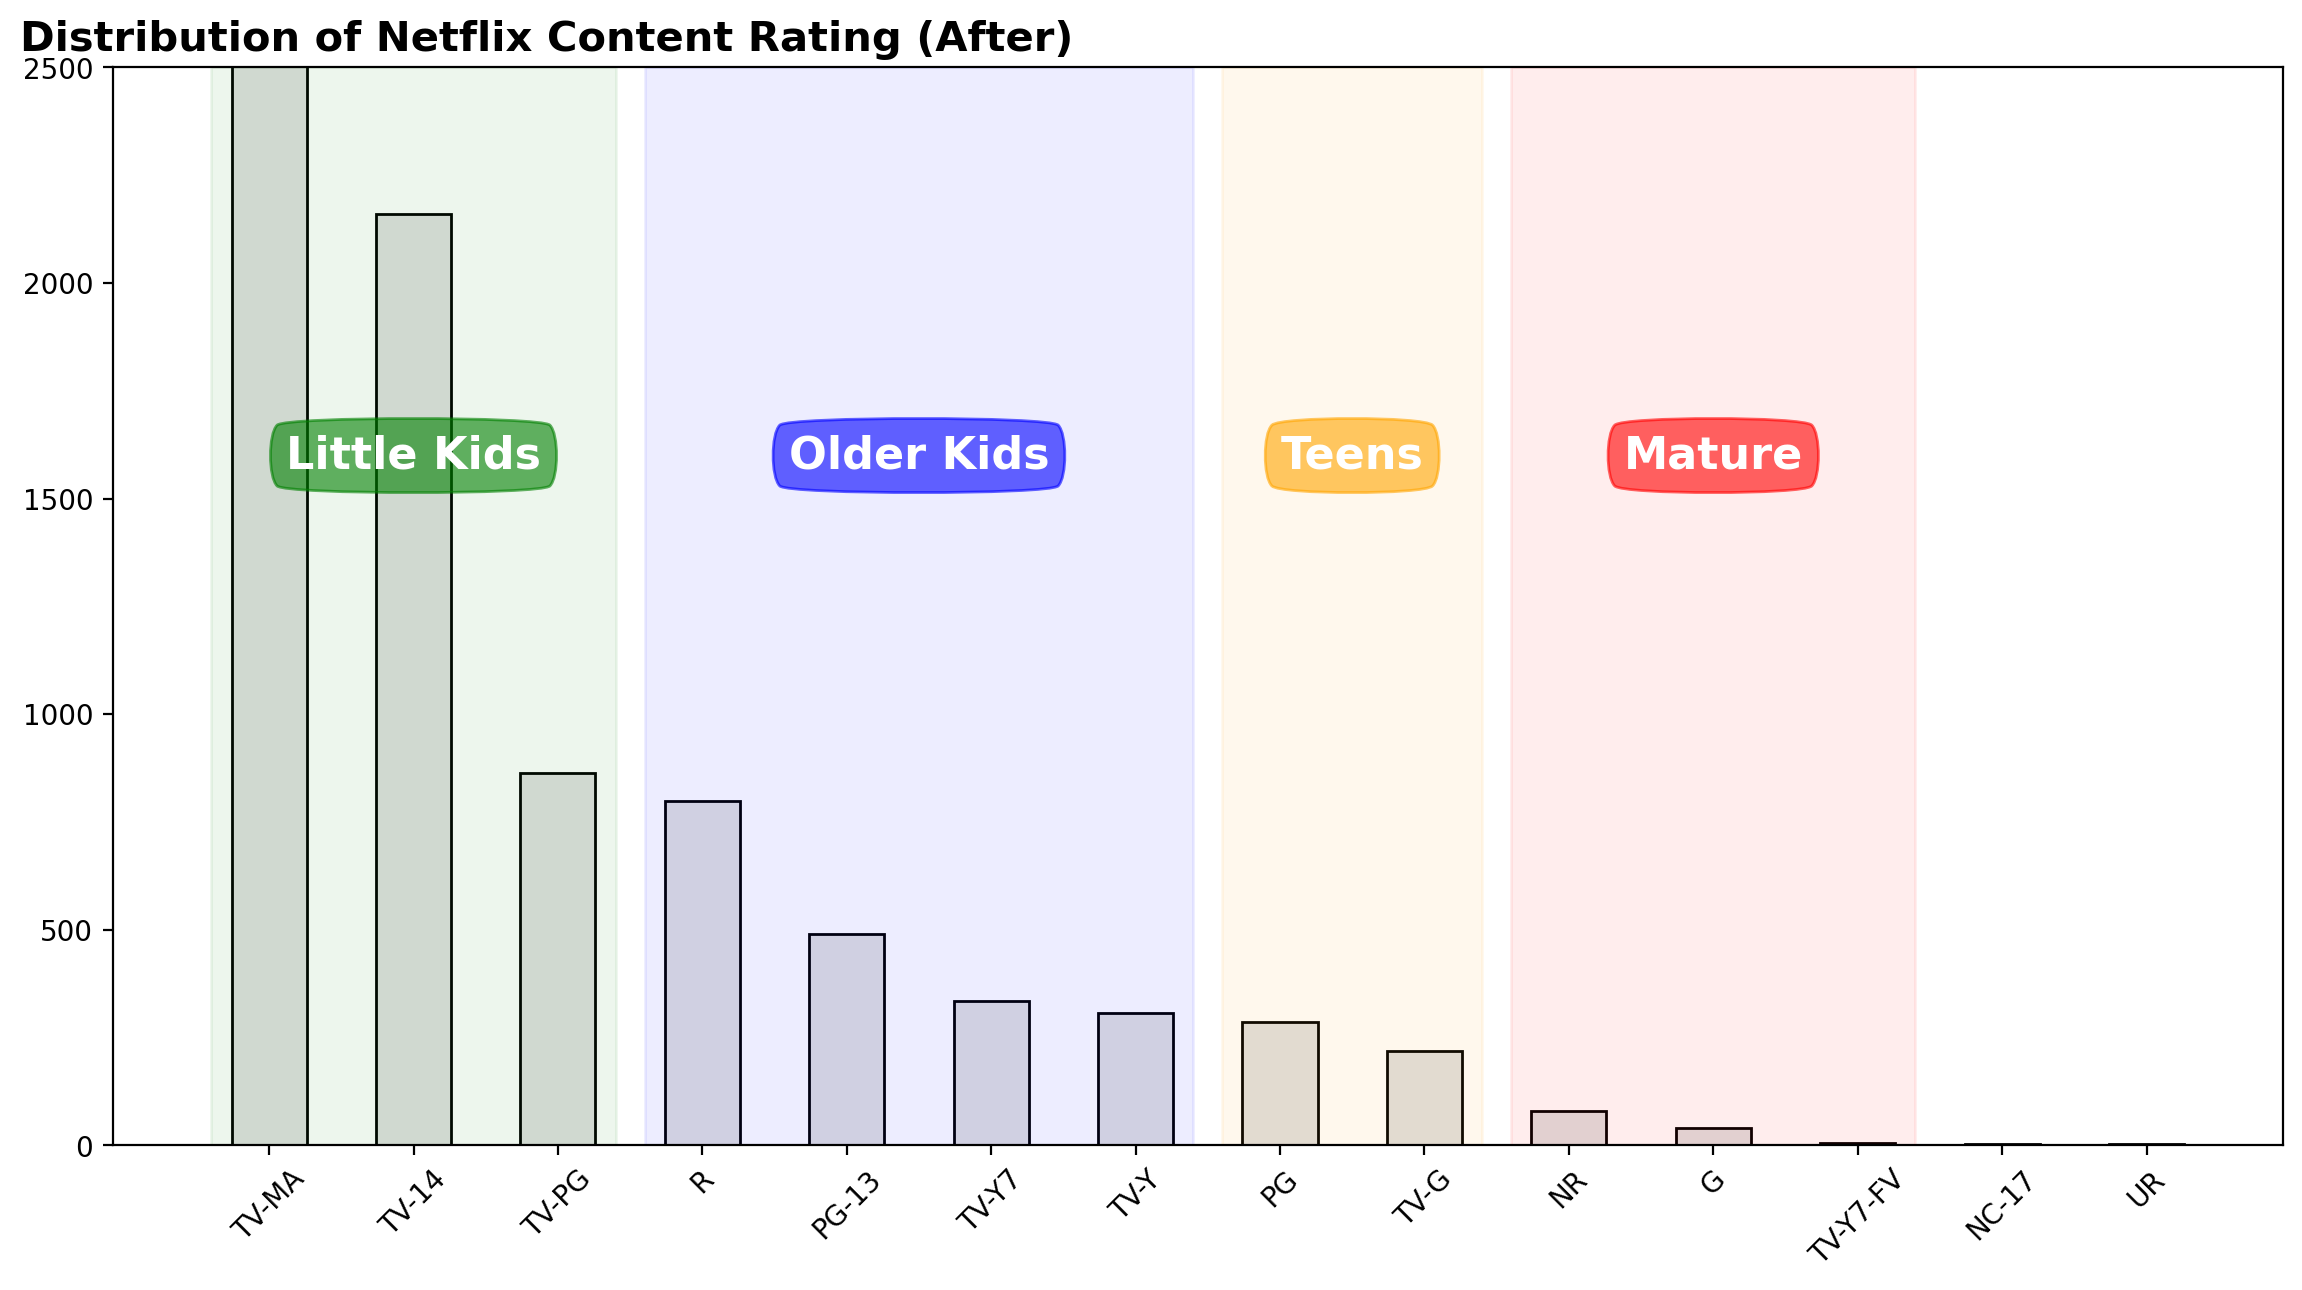

In [38]:
# Vérifier les valeurs uniques dans 'rating'
print(netflix_data['rating'].unique())

# Supprimer les valeurs NaN dans 'rating'
netflix_data = netflix_data.dropna(subset=['rating'])

# Compter les occurrences des classifications
rating_counts = netflix_data['rating'].value_counts()

# Fonction pour tracer le graphique
def rating_barplot(data, title, height, h_lim=None):
    fig, ax = plt.subplots(1, 1, figsize=(14, 7), dpi=200)
    if h_lim:
        ax.set_ylim(0, h_lim)
    
    ax.bar(data.index, data, color="#e0e0e0", width=0.52, edgecolor='black')

    color = ['green', 'blue', 'orange', 'red']
    span_range = [[0, 2], [3, 6], [7, 8], [9, 11]]
    
    for idx, sub_title in enumerate(['Little Kids', 'Older Kids', 'Teens', 'Mature']):
        ax.annotate(sub_title,
                    xy=(sum(span_range[idx]) / 2, height),
                    xytext=(0, 0), textcoords='offset points',
                    va="center", ha="center",
                    color="w", fontsize=16, fontweight='bold',
                    bbox=dict(boxstyle='round4', pad=0.4, color=color[idx], alpha=0.6))
        ax.axvspan(span_range[idx][0] - 0.4, span_range[idx][1] + 0.4, color=color[idx], alpha=0.07)
    
    ax.set_title(f'Distribution of {title} Rating (After)', fontsize=15, fontweight='bold', position=(0.20, 1.0 + 0.03))
    plt.xticks(rotation=45)
    plt.show()

# Appliquer la fonction sur la colonne 'rating' corrigée
rating_barplot(rating_counts, 'Netflix Content', 1600, 2500)

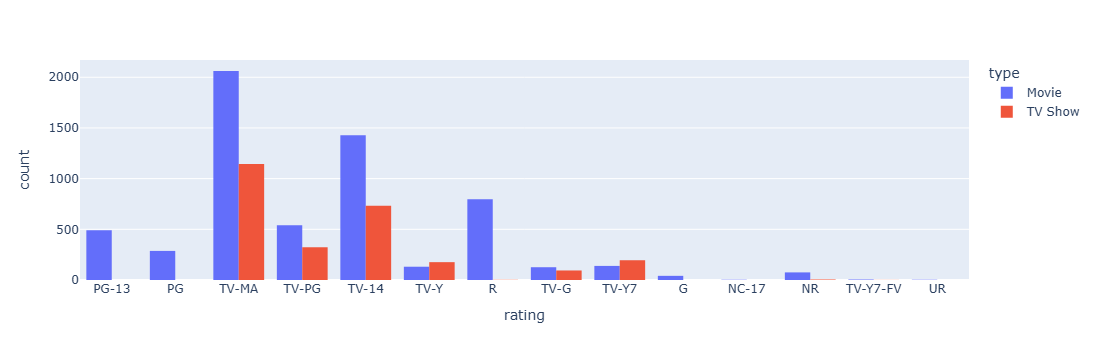

In [39]:
fig = px.histogram(netflix_data, x='rating', color='type', barmode='group')
fig.show()

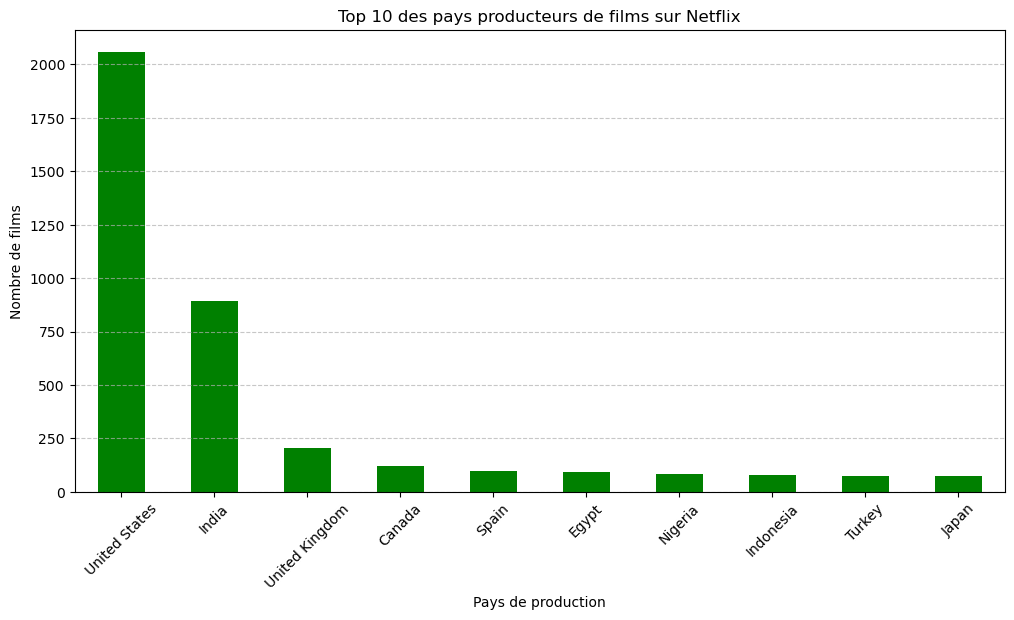

In [40]:
# 3. Number of movies produced by top 10 countries
plt.figure(figsize=(12, 6))
movies_only['country'].value_counts().head(10).plot(kind='bar', color='green')
plt.xlabel("Pays de production")
plt.ylabel("Nombre de films")
plt.title("Top 10 des pays producteurs de films sur Netflix")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [41]:
# Quick feature engineering

# Helper column for various plots
netflix_data['count'] = 1

# Lets retrieve just the first country
netflix_data['first_country'] = netflix_data['country'].dropna().apply(lambda x: x.split(",")[0])
netflix_data['first_country'].head()

netflix_data['first_country'] = netflix_data['first_country'].replace({
    'United States': 'USA',
    'United Kingdom': 'UK',
    'South Korea': 'S. Korea'
})


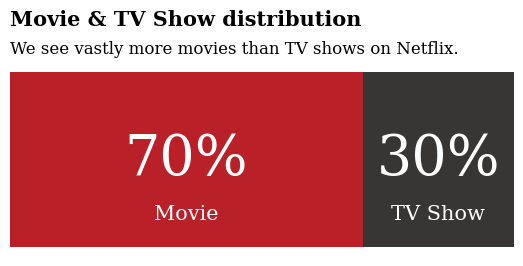

In [42]:
# For viz: Ratio of Movies & TV shows
x = netflix_data.groupby(['type'])['type'].count()
y = len(netflix_data)
r = ((x/y)).round(2)

mf_ratio = pd.DataFrame(r).T

fig, ax = plt.subplots(1,1,figsize=(6.5, 2.5))

ax.barh(mf_ratio.index, mf_ratio['Movie'], 
        color='#b20710', alpha=0.9, label='Male')
ax.barh(mf_ratio.index, mf_ratio['TV Show'], left=mf_ratio['Movie'], 
        color='#221f1f', alpha=0.9, label='Female')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
# movie percentage
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['Movie'][i]*100)}%", 
                   xy=(mf_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')

    ax.annotate("Movie", 
                   xy=(mf_ratio['Movie'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')
    
    
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['TV Show'][i]*100)}%", 
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')
    ax.annotate("TV Show", 
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')

# Title & Subtitle
fig.text(0.125,1.03,'Movie & TV Show distribution', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.125,0.92,'We see vastly more movies than TV shows on Netflix.',fontfamily='serif',fontsize=12)  

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    


#ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

# Removing legend due to labelled plot
ax.legend().set_visible(False)
plt.show()

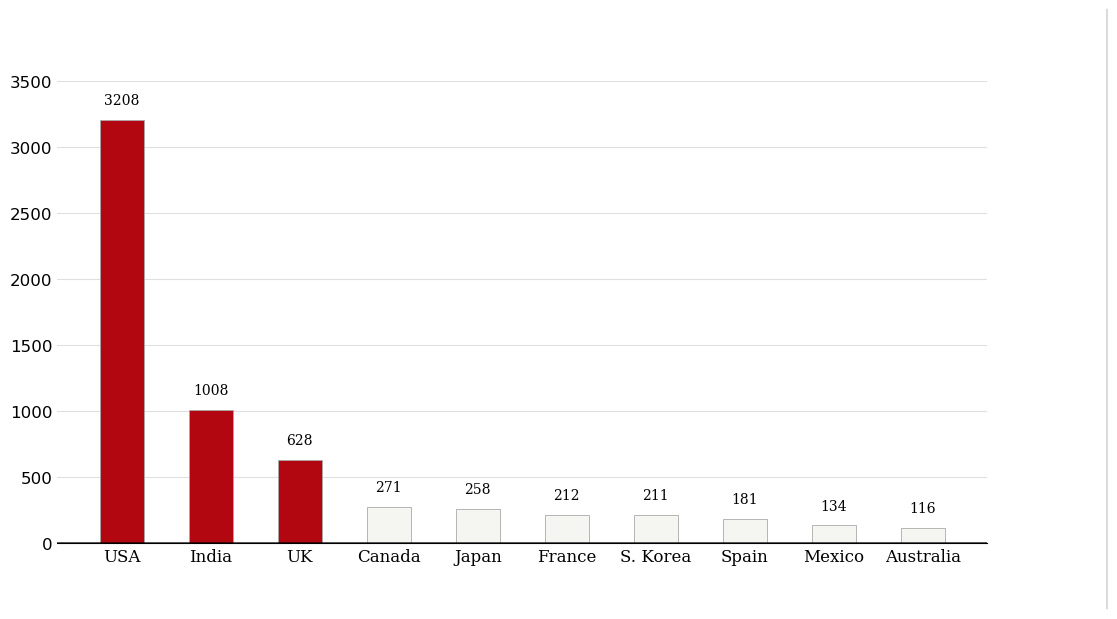

In [43]:
data = netflix_data.groupby('first_country')['count'].sum().sort_values(ascending=False)[:10]


color_map = ['#f5f5f1' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  '#b20710' # color highlight

fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(data.index, data, width=0.5, 
       edgecolor='darkgray',
       linewidth=0.6,color=color_map)

#annotations
for i in data.index:
    ax.annotate(f"{data[i]}", 
                   xy=(i, data[i] + 150), #i like to change this to roughly 5% of the highest cat
                   va = 'center', ha='center',fontweight='light', fontfamily='serif')



# Remove border from plot

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
# Tick labels
ax.set_xticks(range(len(data.index)))  # Définit les positions des ticks
ax.set_xticklabels(data.index, fontfamily='serif', rotation=0)



ax.grid(axis='y', linestyle='-', alpha=0.4)   

grid_y_ticks = np.arange(0, 4000, 500) # y ticks, min, max, then step
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

    
# thicken the bottom line if you want to
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

ax.tick_params(axis='both', which='major', labelsize=12)


l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

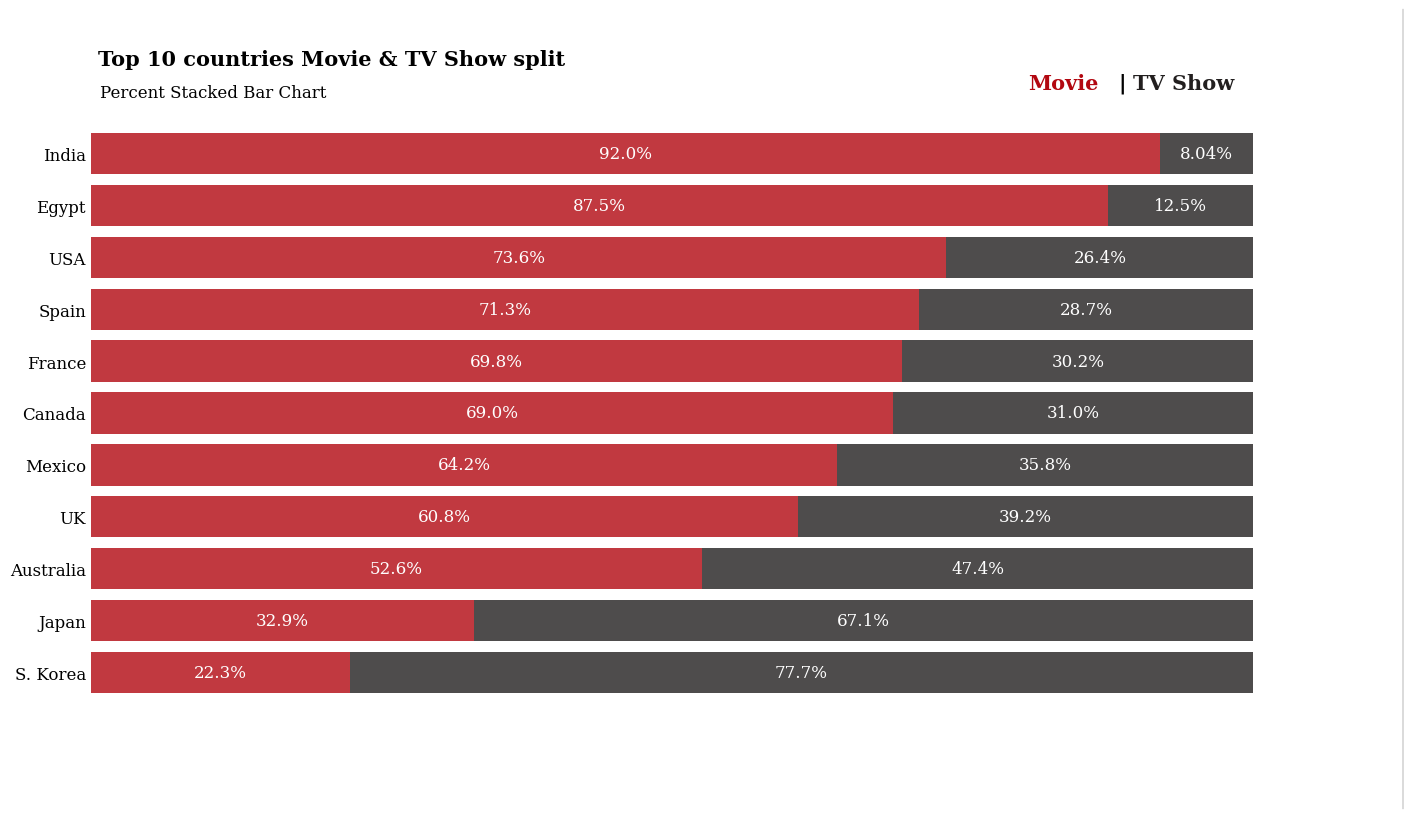

In [44]:
country_order = netflix_data['first_country'].value_counts()[:11].index
data_q2q3 = netflix_data[['type', 'first_country']].groupby('first_country')['type'].value_counts().unstack().loc[country_order]
data_q2q3['sum'] = data_q2q3.sum(axis=1)
data_q2q3_ratio = (data_q2q3.T / data_q2q3['sum']).T[['Movie', 'TV Show']].sort_values(by='Movie',ascending=False)[::-1]




###
fig, ax = plt.subplots(1,1,figsize=(15, 8),)

ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Movie'], 
        color='#b20710', alpha=0.8, label='Movie')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['TV Show'], left=data_q2q3_ratio['Movie'], 
        color='#221f1f', alpha=0.8, label='TV Show')


ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks(range(len(data_q2q3_ratio.index)))  # Définit les positions des ticks
ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='serif', fontsize=11)

# male percentage
for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['Movie'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['TV Show'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]+data_q2q3_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')
    

fig.text(0.13, 0.93, 'Top 10 countries Movie & TV Show split', fontsize=15, fontweight='bold', fontfamily='serif')   
fig.text(0.131, 0.89, 'Percent Stacked Bar Chart', fontsize=12,fontfamily='serif')   

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
#ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

fig.text(0.75,0.9,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.81,0.9,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.82,0.9,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

import matplotlib.lines as lines
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

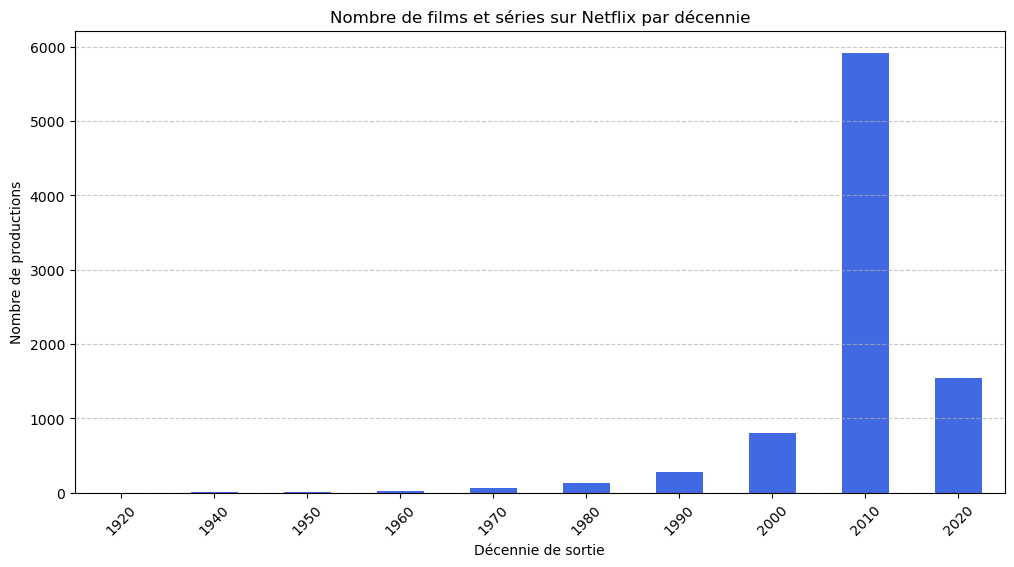

In [45]:
# 1. Évolution du nombre de productions Netflix par décennie
plt.figure(figsize=(12, 6))
netflix_data['decade'] = (netflix_data['release_year'] // 10) * 10
netflix_data['decade'].value_counts().sort_index().plot(kind='bar', color='royalblue')
plt.xlabel("Décennie de sortie")
plt.ylabel("Nombre de productions")
plt.title("Nombre de films et séries sur Netflix par décennie")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

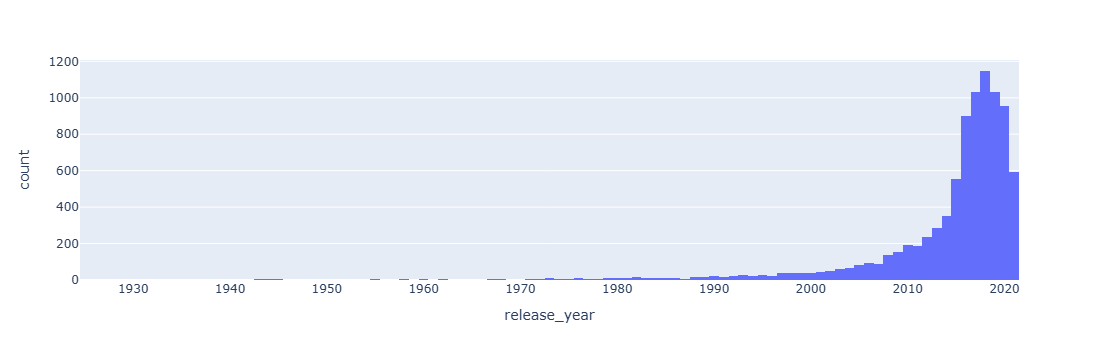

In [46]:
fig = px.histogram(netflix_data, x='release_year', barmode='group')
fig.show()

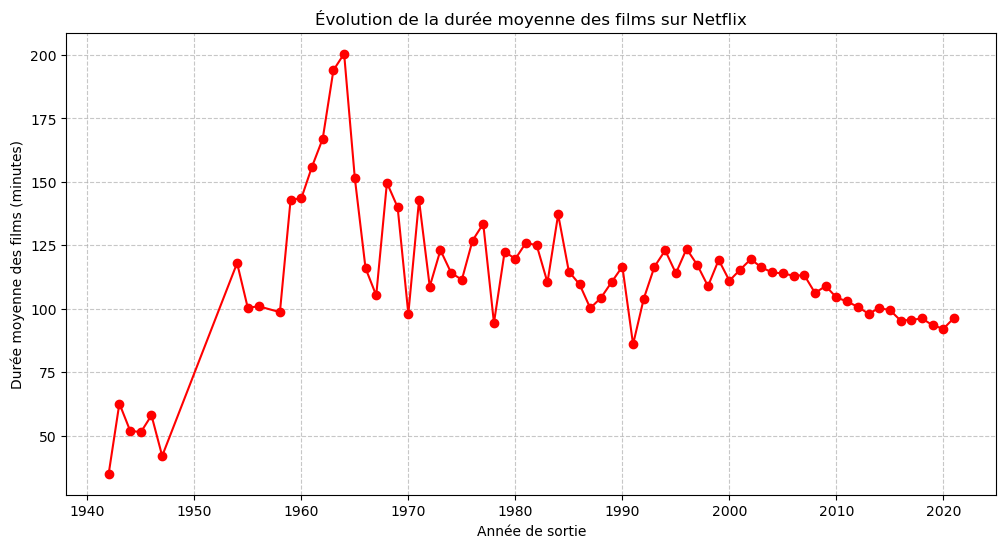

In [47]:
# 2. Durée moyenne des films par année
netflix_data['duration_num'] = netflix_data['duration'].str.extract(r'(\d+)').astype(float)
movies_only = netflix_data[netflix_data['type'] == 'Movie']
plt.figure(figsize=(12, 6))
movies_only.groupby('release_year')['duration_num'].mean().plot(kind='line', marker='o', color='red')
plt.xlabel("Année de sortie")
plt.ylabel("Durée moyenne des films (minutes)")
plt.title("Évolution de la durée moyenne des films sur Netflix")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

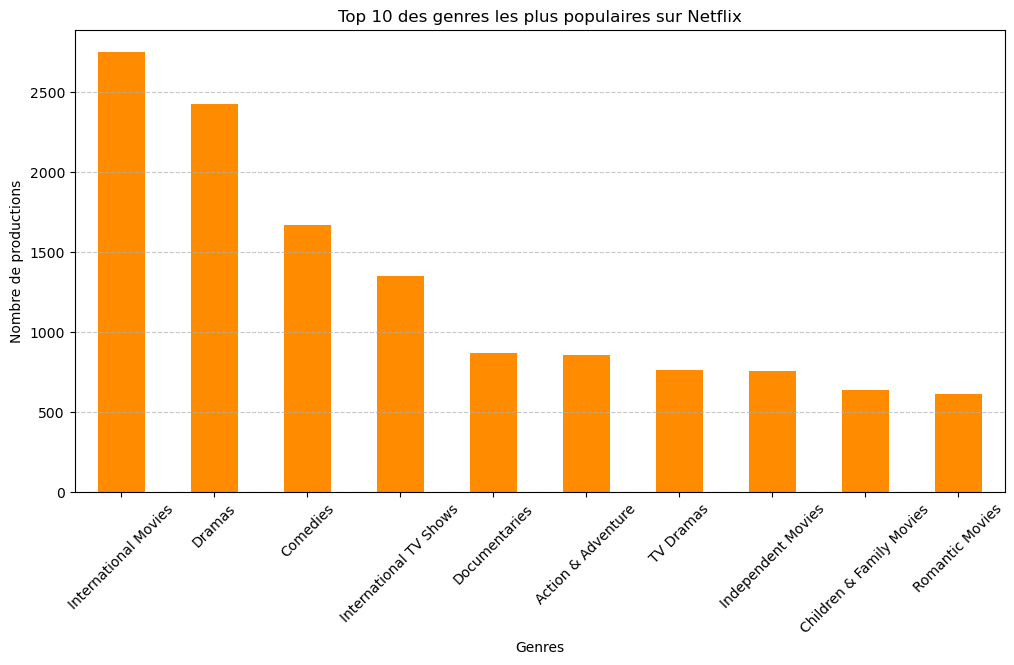

In [48]:
# 3. Top 10 des genres les plus populaires
listed_genres = netflix_data['listed_in'].str.get_dummies(sep=', ')
genre_counts = listed_genres.sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='darkorange')
plt.xlabel("Genres")
plt.ylabel("Nombre de productions")
plt.title("Top 10 des genres les plus populaires sur Netflix")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

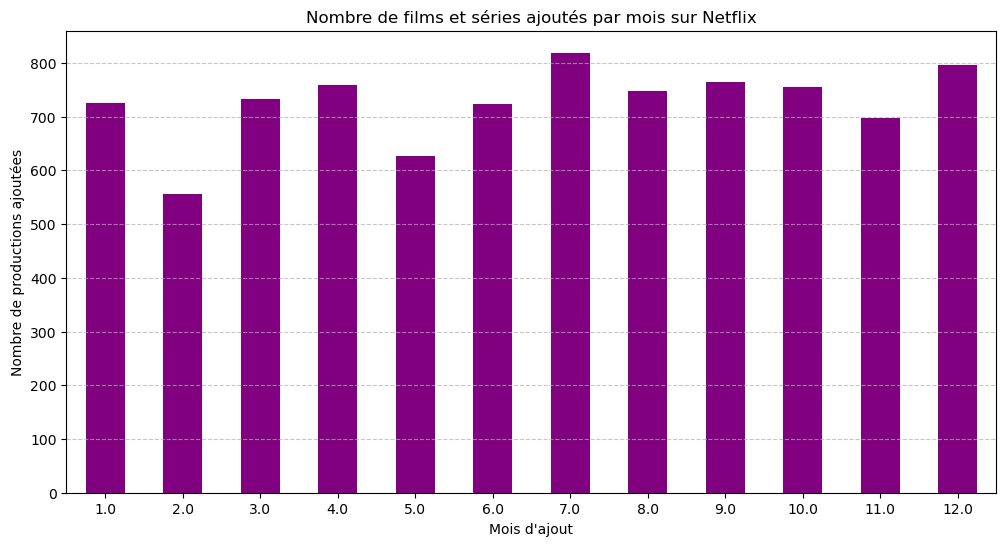

In [49]:
# 4. Nombre de films et séries ajoutés chaque mois
netflix_data['date_added'] = pd.to_datetime(netflix_data['date_added'], errors='coerce')
netflix_data['month_added'] = netflix_data['date_added'].dt.month
plt.figure(figsize=(12, 6))
netflix_data['month_added'].value_counts().sort_index().plot(kind='bar', color='purple')
plt.xlabel("Mois d'ajout")
plt.ylabel("Nombre de productions ajoutées")
plt.title("Nombre de films et séries ajoutés par mois sur Netflix")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

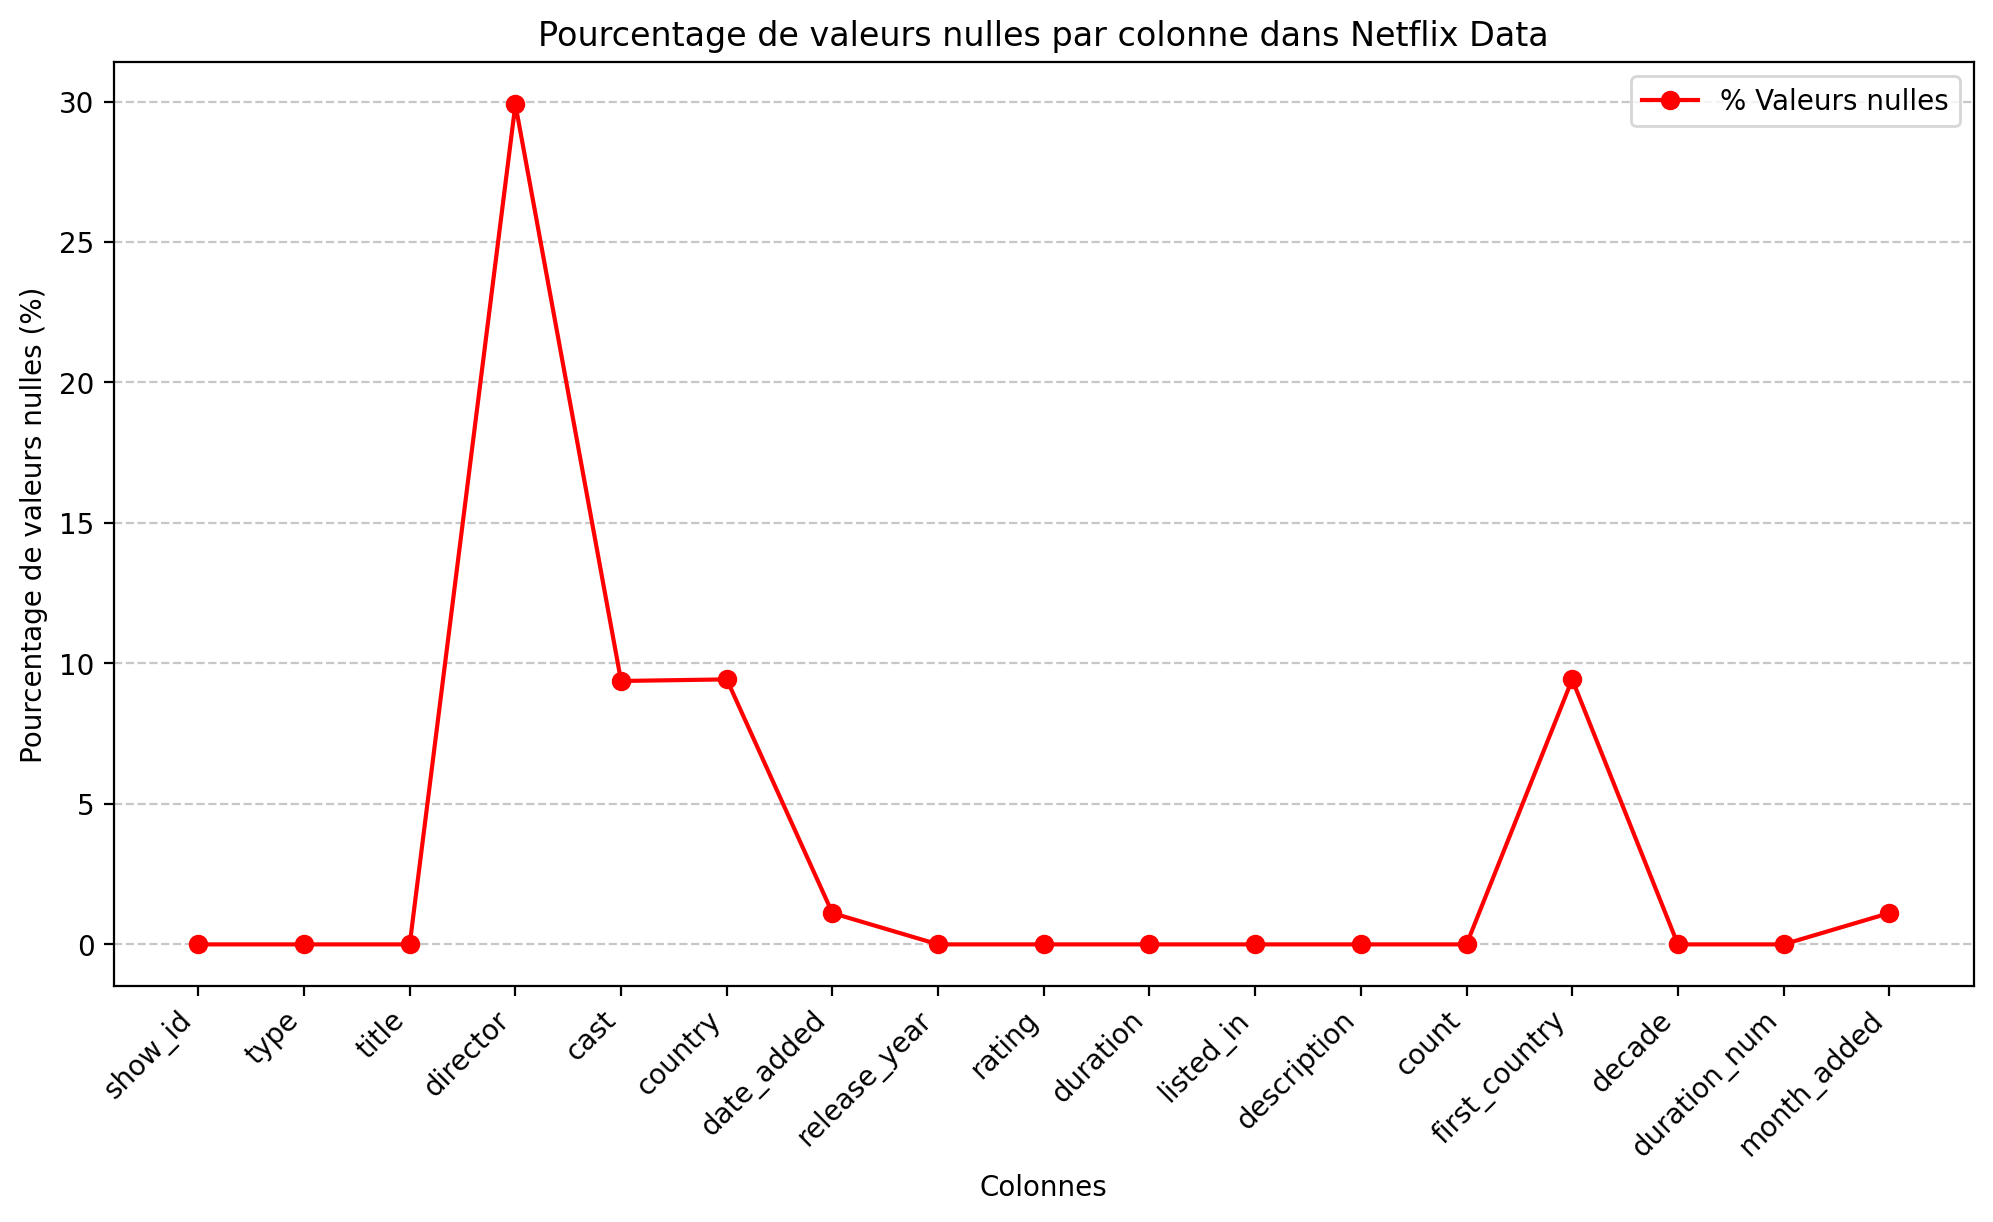

In [50]:
import matplotlib.pyplot as plt

# 📊 Calculer le pourcentage de valeurs nulles par colonne
missing_values = netflix_data.isnull().sum()
missing_percentage = (missing_values / len(netflix_data)) * 100

# ✅ Tracer la courbe des valeurs nulles
plt.figure(figsize=(12, 6), dpi=200)
plt.plot(missing_percentage.index, missing_percentage, marker='o', linestyle='-', color='red', label="% Valeurs nulles")

# 🎨 Mise en forme du graphique
plt.xticks(rotation=45, ha='right')
plt.xlabel("Colonnes")
plt.ylabel("Pourcentage de valeurs nulles (%)")
plt.title("Pourcentage de valeurs nulles par colonne dans Netflix Data")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 🔍 Afficher le graphique
plt.show()


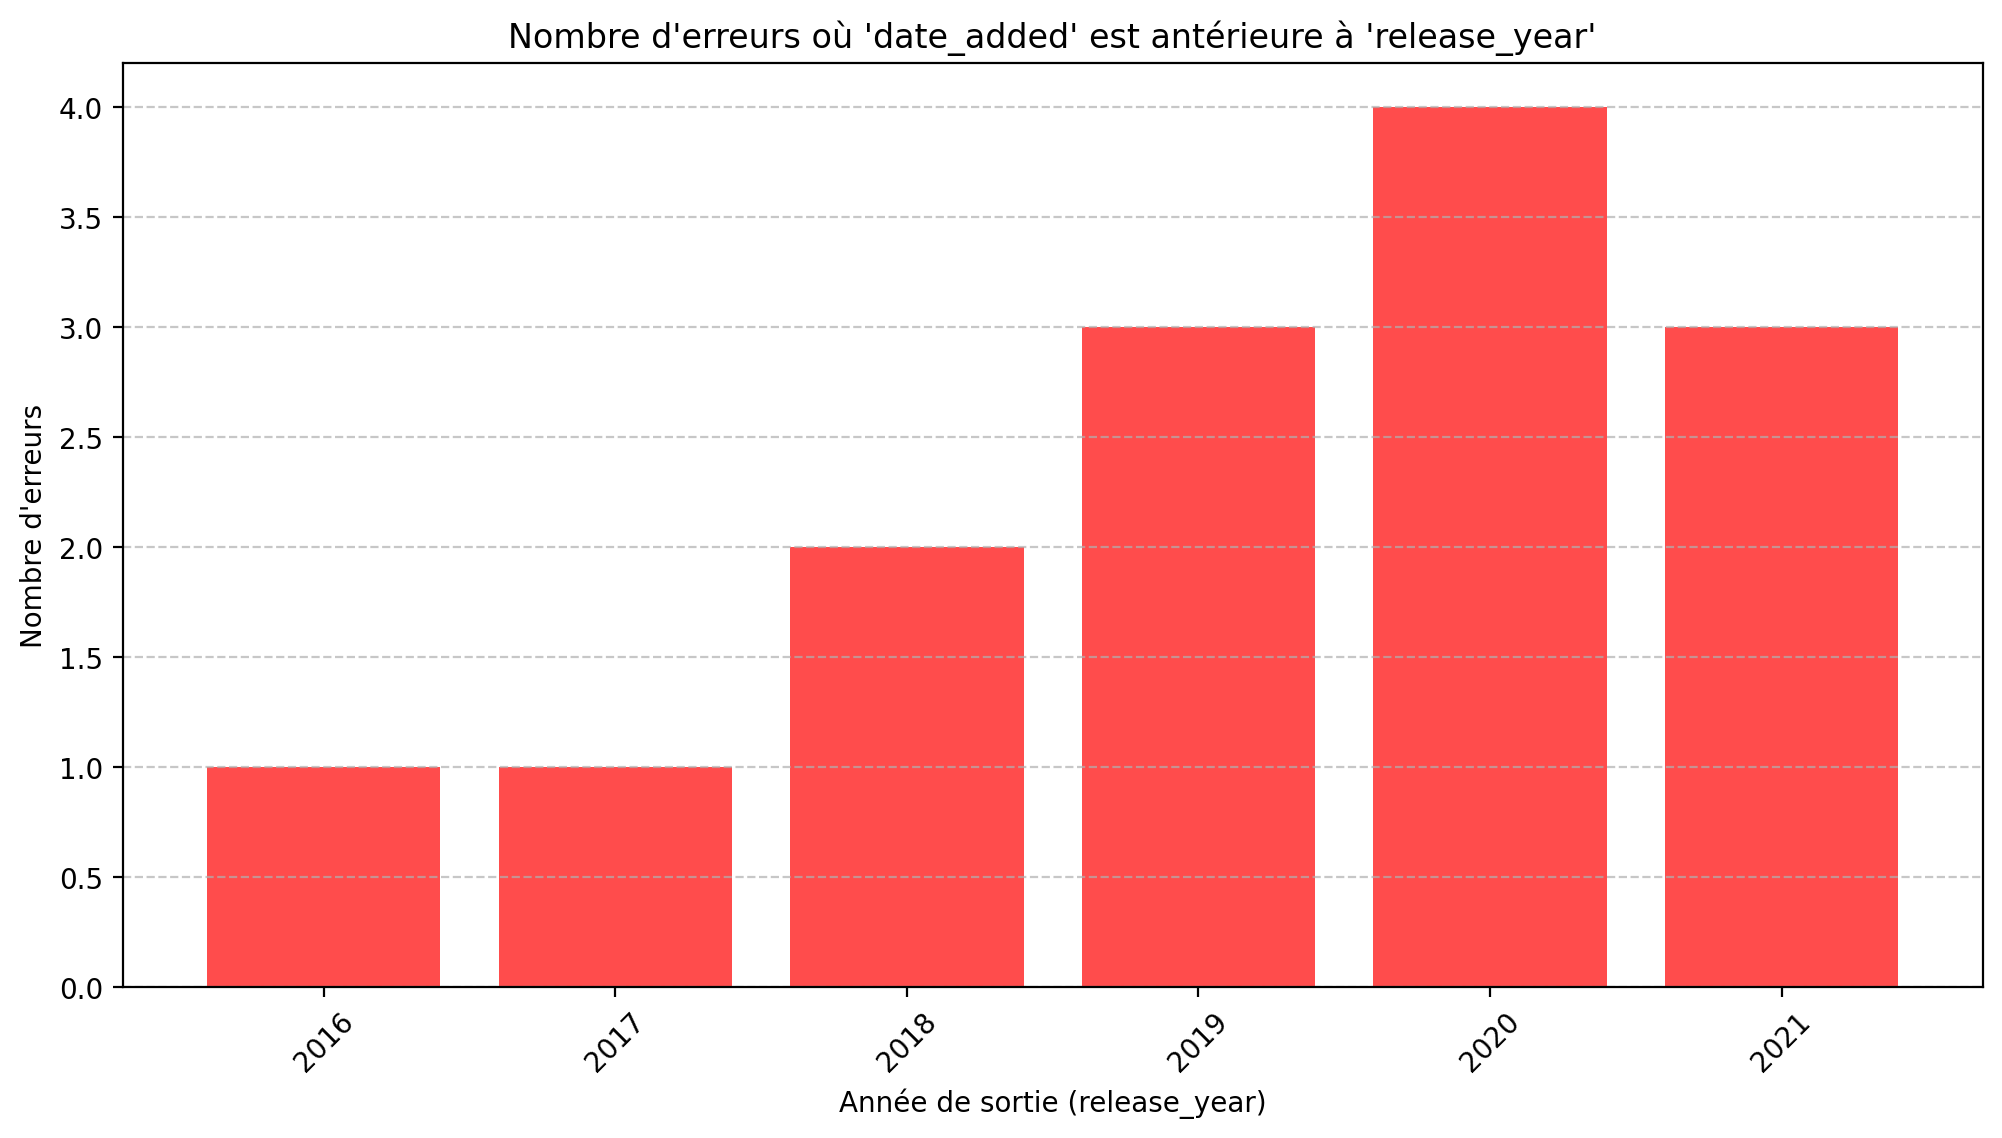

In [96]:
# 📊 Identifier les lignes où 'date_added' est antérieure à 'release_year'
netflix_data['date_added'] = pd.to_datetime(netflix_data['date_added'], errors='coerce')
netflix_data['release_year'] = pd.to_numeric(netflix_data['release_year'], errors='coerce')

invalid_dates = netflix_data[(netflix_data['date_added'].notnull()) & (netflix_data['release_year'].notnull())]
invalid_dates = invalid_dates[invalid_dates['date_added'].dt.year < invalid_dates['release_year']]

# 📊 Compter les occurrences des erreurs par année de sortie
invalid_year_counts = invalid_dates['release_year'].value_counts().sort_index()

# ✅ Tracer le graphique des erreurs de date
plt.figure(figsize=(12, 6), dpi=200)
plt.bar(invalid_year_counts.index, invalid_year_counts.values, color='red', alpha=0.7)

# 🎨 Mise en forme du graphique
plt.xlabel("Année de sortie (release_year)")
plt.ylabel("Nombre d'erreurs")
plt.title("Nombre d'erreurs où 'date_added' est antérieure à 'release_year'")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 🔍 Afficher le graphique
plt.show()

# 🏁 Conclusion et Perspectives

📌 Ce projet nous a permis d'explorer les données Netflix et d'extraire des tendances intéressantes.  
🔍 Une analyse plus approfondie pourrait inclure :
- L'étude des tendances par genre et par année
- Une analyse des acteurs et réalisateurs les plus populaires
- L'intégration d'autres sources de données pour enrichir l'analyse
